#### Created by Najee Stubbs | Created on 10/21/2023 | Revision 2 {**Considered Final**}

---
# Introduction to the Heat Flux Prediction Code

This code is dedicated to predicting heat flux values based on temperature readings. Two machine learning models, a Multi-Layer Perceptron (MLP) and a Gaussian Process Regression (GPR), are employed to understand and predict the relationship between temperature and heat flux.

## Key Components:
1. **Data Loading and Visualization**: The user is prompted to upload a tab-separated data file. This file should contain temperature values in its first column and corresponding heat flux values in the second. Once loaded, the data is visualized as a line plot of heat flux over temperature.
2. **MLP Model**: An MLP model is defined and trained using TensorFlow and Keras. This model has three hidden layers with L2 regularization and LeakyReLU activation. Training incorporates early stopping to avoid overfitting.
3. **GPR Model**: A Gaussian Process Regression model is defined and trained using the scikit-learn library. The GPR uses a fixed-length scale Radial Basis Function (RBF) kernel.
4. **K-Fold Cross-Validation**: Both the MLP and GPR models undergo k-fold cross-validation. This process helps in understanding the model's performance consistency across different data splits and aids in selecting the best performing model configuration.
5. **Results Visualization**:
   - **Loss and RMSE Comparison**: After cross-validation, the loss and RMSE for each fold are plotted side-by-side for both models, allowing for a direct comparison of their performances.
   - **Prediction Results**: The best MLP and GPR models (based on RMSE) are used to make predictions on a test set. The predicted heat flux values are plotted against the original values, and residuals are visualized to understand the models' prediction accuracy.

## Execution Flow:
Upon execution, the code performs the following sequence of operations:
1. Loads the data from a user-provided file.
2. Splits the data into training (for cross-validation) and test sets.
3. Conducts k-fold cross-validation for both MLP and GPR models.
4. Visualizes a comparison of the loss and RMSE between the two models over each fold.
5. Displays prediction results and residuals of the best models on the test set.

---

# 1. Import Libraries

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from google.colab import files
from tqdm.notebook import tqdm

# 2. Define Function to Load and Visualize Dataset

In [ ]:
def load_data():
  """
  Load and visualize data from a file uploaded by the user.

  The function expects the file to contain tab-separated values with the first row as headers.
  The first column should represent temperature values, while the second column should represent heat flux values.

  After loading the data, it visualizes the heat flux over temperature using a line plot.

  Returns:
      tuple: A tuple containing two numpy arrays - temperature and heatflux.
  """

  # Allow user to upload a file
  uploaded = files.upload()

  # Extract the filename from the uploaded files (assuming only one file is uploaded)
  filename = list(uploaded.keys())[0]

  # Load the data from the file, skipping the first row (headers)
  # and unpacking the columns into separate arrays
  data = np.loadtxt(filename, delimiter='\t', skiprows=1, unpack=True)

  # Extract temperature and heatflux data from the loaded data
  temperature, heatflux = data[0], data[1]

  # Visualize the data using a line plot
  plt.figure(figsize=(14, 6))
  plt.plot(temperature, heatflux)
  plt.xlabel('Temperature')
  plt.ylabel('Heatflux')
  plt.title('Visualization of Original Data: Heatflux over Temperature')
  plt.show()

  return temperature, heatflux

# 3. Define Functions to Build MLP & GPR Models

In [ ]:
def train_mlp_model(X_train, y_train, X_val, y_val):
  """
  Train a multi-layer perceptron (MLP) model on given training data and validate on given validation data.

  The MLP has the following architecture:
  - Input layer
  - Dense layer with 128 neurons, L2 regularization, and LeakyReLU activation
  - Dense layer with 64 neurons, L2 regularization, and LeakyReLU activation
  - Dense layer with 32 neurons, L2 regularization, and LeakyReLU activation
  - Output layer with 1 neuron (linear activation by default)

  Training is performed using the Adam optimizer, Mean Squared Error loss, and early stopping.

  Parameters:
  - X_train: Training feature data
  - y_train: Training target data
  - X_val: Validation feature data
  - y_val: Validation target data

  Returns:
  - model: Trained TensorFlow/Keras model
  - val_loss: Validation loss
  - val_rmse: Root Mean Squared Error on the validation set
  """

  # Define the MLP model architecture
  model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(1,)),
      tf.keras.layers.LeakyReLU(alpha=0.01),
      tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
      tf.keras.layers.LeakyReLU(alpha=0.01),
      tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
      tf.keras.layers.LeakyReLU(alpha=0.01),
      tf.keras.layers.Dense(1)])

  # Compile the model with the specified loss function, optimizer, and evaluation metric
  model.compile(
      loss=tf.keras.losses.MeanSquaredError(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=[tf.keras.metrics.RootMeanSquaredError()])

  # Define early stopping criteria for training
  earlyStopping = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss',
      patience=10,
      verbose=0,
      mode='auto',
      restore_best_weights=True)

  # Train the model
  model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val),
            callbacks=[earlyStopping], verbose=0)

  # Evaluate the model on the validation set
  eval_results = model.evaluate(X_val, y_val, verbose=0)

  return model, eval_results[0], eval_results[1]

In [ ]:
def train_gpr_model(X_train, y_train, X_val, y_val):
  """
  Train a Gaussian Process Regression (GPR) model on given training data and validate on given validation data.

  The GPR model uses a fixed-length scale Radial Basis Function (RBF) kernel. Data normalization is not applied,
  and a small noise level (alpha) is considered for better numerical stability during training.

  Parameters:
  - X_train: Training feature data
  - y_train: Training target data
  - X_val: Validation feature data
  - y_val: Validation target data

  Returns:
  - model: Trained GaussianProcessRegressor model
  - val_loss: Mean Squared Error on the validation set
  - val_rmse: Root Mean Squared Error on the validation set
  """

  # Define the RBF kernel with a fixed length scale
  kernel = RBF(length_scale=1.0, length_scale_bounds='fixed')

  # Create the Gaussian Process Regressor model with the specified kernel and parameters
  model = GaussianProcessRegressor(kernel=kernel, normalize_y=False, random_state=1, alpha=0.001)

  # Train the GPR model (reshape the input to ensure it's 2D)
  model.fit(X_train.reshape(-1, 1), y_train)

  # Predict on the validation set
  y_pred_val = model.predict(X_val.reshape(-1, 1))

  # Calculate the mean squared error and root mean squared error for validation predictions
  val_loss = mean_squared_error(y_val, y_pred_val)
  val_rmse = np.sqrt(val_loss)

  return model, val_loss, val_rmse

# 4. Define Functions to Train MLP & GPR Models, employing KFolds Cross-Validation

In [ ]:
def k_fold_cross_validation(model_function, X_temp, y_temp, n_splits, model_name):
  """
  Perform k-fold cross-validation on the given dataset using a specified model training function.

  Parameters:
  - model_function: Function used to train the model; should return trained model, validation loss, and validation RMSE.
  - X_temp: Feature data for cross-validation
  - y_temp: Target data for cross-validation
  - n_splits: Number of splits (folds) for cross-validation
  - model_name: Name of the model (used for progress bar description)

  Returns:
  - dict: A dictionary containing:
    * eval_losses: List of validation losses for each fold
    * eval_rmses: List of validation RMSEs for each fold
    * best_fold: Index of the fold with the lowest RMSE
    * best_model: Trained model from the fold with the lowest RMSE
    * avg_eval_loss: Average validation loss across all folds
    * avg_eval_rmse: Average validation RMSE across all folds
  """

  # Initialize KFold cross-validation with specified parameters
  kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

  # Lists to store evaluation metrics and trained models for each fold
  eval_losses = []
  eval_rmses = []
  trained_models = []

  # Initialize a progress bar to monitor the cross-validation process
  fold_progress_bar = tqdm(total=n_splits, position=0, desc=f'{model_name} Fold Progress')

  # Loop through each fold
  for train_index, val_index in kf.split(X_temp):
    # Split the data into training and validation sets for the current fold
    X_train, X_val = X_temp[train_index], X_temp[val_index]
    y_train, y_val = y_temp[train_index], y_temp[val_index]

    # Train the model using the provided model_function
    trained_model, val_loss, val_rmse = model_function(X_train, y_train, X_val, y_val)

    # Store the trained model and evaluation metrics for the current fold
    trained_models.append(trained_model)
    eval_losses.append(val_loss)
    eval_rmses.append(val_rmse)

    # Update the progress bar
    fold_progress_bar.update(1)

  # Close the progress bar after all folds are processed
  fold_progress_bar.close()

  # Determine the fold with the best (lowest) RMSE
  best_fold = np.argmin(eval_rmses)

  # Calculate average evaluation metrics across all folds
  avg_eval_loss = np.mean(eval_losses)
  avg_eval_rmse = np.mean(eval_rmses)

  # Compile results into a dictionary
  results = {
      'eval_losses': eval_losses,
      'eval_rmses': eval_rmses,
      'best_fold': best_fold,
      'best_model': trained_models[best_fold],
      'avg_eval_loss': avg_eval_loss,
      'avg_eval_rmse': avg_eval_rmse}

  return results

# 5. Define Function to Compare the Training Performance of the MLP and GPR Models

In [ ]:
def plot_loss_and_rmse_comparison(results_mlp, results_gpr):
  """
  Plot a side-by-side comparison of the loss and RMSE for MLP and GPR models over k-fold cross-validation.

  Parameters:
  - results_mlp: Dictionary containing evaluation metrics for the MLP model from k-fold cross-validation.
  - results_gpr: Dictionary containing evaluation metrics for the GPR model from k-fold cross-validation.

  The dictionaries are expected to have the following keys:
  'eval_losses', 'eval_rmses', 'avg_eval_loss', and 'avg_eval_rmse'.

  The function will plot two subplots:
  1. Comparison of losses per fold for both models.
  2. Comparison of RMSEs per fold for both models.
  """

  # Determine the number of folds from the results
  folds = range(1, len(results_mlp['eval_losses']) + 1)

  # Create a figure with a specified size
  plt.figure(figsize=(15, 6))

  # Plot Losses per Fold
  plt.subplot(1, 2, 1)  # Create the first subplot (1 row, 2 columns, first subplot)
  plt.plot(folds, results_mlp['eval_losses'], 'o-', label=f'MLP Loss (Avg: {results_mlp["avg_eval_loss"]:.4f})')
  plt.plot(folds, results_gpr['eval_losses'], 's-', label=f'GPR Loss (Avg: {results_gpr["avg_eval_loss"]:.4f})')
  plt.xlabel('Fold Number')
  plt.ylabel('Loss')
  plt.title('Loss Comparison per Fold')
  plt.legend()
  plt.grid(True)

  # Plot RMSEs per Fold
  plt.subplot(1, 2, 2)  # Create the second subplot (1 row, 2 columns, second subplot)
  plt.plot(folds, results_mlp['eval_rmses'], 'o-', label=f'MLP RMSE (Avg: {results_mlp["avg_eval_rmse"]:.4f})')
  plt.plot(folds, results_gpr['eval_rmses'], 's-', label=f'GPR RMSE (Avg: {results_gpr["avg_eval_rmse"]:.4f})')
  plt.xlabel('Fold Number')
  plt.ylabel('RMSE')
  plt.title('RMSE Comparison per Fold')
  plt.legend()
  plt.grid(True)

  # Adjust the layout to ensure no overlap
  plt.tight_layout()

  # Display the plots
  plt.show()

# 6. Define Function to Compare the Performance of the MLP and GPR Models

In [ ]:
def plot_prediction_results(results_mlp, results_gpr, X_test, y_test, threshold=0.05):
  """
  Plot prediction results for the best MLP and GPR models on test data, including:
  - Predicted vs Original Heat Flux
  - Original and Predicted Heat Flux vs Temperature
  - Residuals comparison between MLP and GPR

  Parameters:
  - results_mlp: Dictionary containing evaluation metrics and the best MLP model from k-fold cross-validation.
  - results_gpr: Dictionary containing evaluation metrics and the best GPR model from k-fold cross-validation.
  - X_test: Test feature data
  - y_test: Test target data
  - threshold (optional): Threshold for calculating prediction accuracy based on residuals. Default is 0.05.

  The function uses the 'best_model' key from the results dictionaries to make predictions on the test data.
  """

  # Extract the best models from the results dictionaries
  MLP_model = results_mlp['best_model']
  GPR_model = results_gpr['best_model']

  # Generate predictions using the best models
  y_preds = {
      'MLP': MLP_model.predict(X_test).squeeze(),
      'GPR': GPR_model.predict(X_test.reshape(-1, 1))}

  # Set the figure size for the plots
  plt.figure(figsize=(24, 18))

  # Plot Predicted vs Original Heat Flux for both models
  for idx, (key, y_pred) in enumerate(y_preds.items()):
    plt.subplot(3, 2, idx + 1)
    plt.scatter(y_test, y_pred, color='blue', label=f'Predicted {key}', marker='.')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Best Trend')
    plt.xlabel('Original Heat Flux')
    plt.ylabel('Predicted Heat Flux')
    best_fold = results_mlp['best_fold'] if key == 'MLP' else results_gpr['best_fold']
    plt.title(f'Predicted vs Original Heat Flux using {key} (Best Fold: {best_fold + 1})')
    plt.legend()

  # Plot Original and Predicted Heat Flux vs Temperature for both models
  for idx, (key, y_pred) in enumerate(y_preds.items()):
    plt.subplot(3, 2, idx + 3)
    plt.scatter(X_test, y_test, color='blue', label='Original Data', marker='.')
    plt.scatter(X_test, y_pred, color='red', label=f'Predicted {key}', marker='.')
    plt.xlabel('Temperature')
    plt.ylabel('Heat Flux')
    best_fold = results_mlp['best_fold'] if key == 'MLP' else results_gpr['best_fold']
    plt.title(f'Original and Predicted Heat Flux vs Temperature using {key} (Best Fold: {best_fold + 1})')
    plt.legend()

  # Calculate residuals and prediction accuracy for both models
  residuals_mlp = y_test - y_preds['MLP']
  residuals_gpr = y_test - y_preds['GPR']
  accurate_mlp = np.mean(np.abs(residuals_mlp) <= threshold * np.abs(y_test)) * 100
  accurate_gpr = np.mean(np.abs(residuals_gpr) <= threshold * np.abs(y_test)) * 100

  # Plot Residuals comparison between MLP and GPR
  plt.subplot(3, 2, 5)
  plt.scatter(X_test, residuals_mlp, color='blue', label=f'MLP Residuals (Accuracy: {accurate_mlp:.2f}%)', s=10)
  plt.scatter(X_test, residuals_gpr, color='red', label=f'GPR Residuals (Accuracy: {accurate_gpr:.2f}%)', s=10)
  plt.axhline(0, color='green', linestyle='--')  # Plot a horizontal line at y=0 for reference
  plt.xlabel('Temperature')
  plt.ylabel('Residuals')
  plt.title('Residuals Comparison between MLP and GPR')
  plt.legend()

  # Adjust the layout to prevent overlap
  plt.tight_layout()

  # Display the plots
  plt.show()

# 7. Execute Code

Saving boiling-32_temp_heat_flux.txt to boiling-32_temp_heat_flux (24).txt


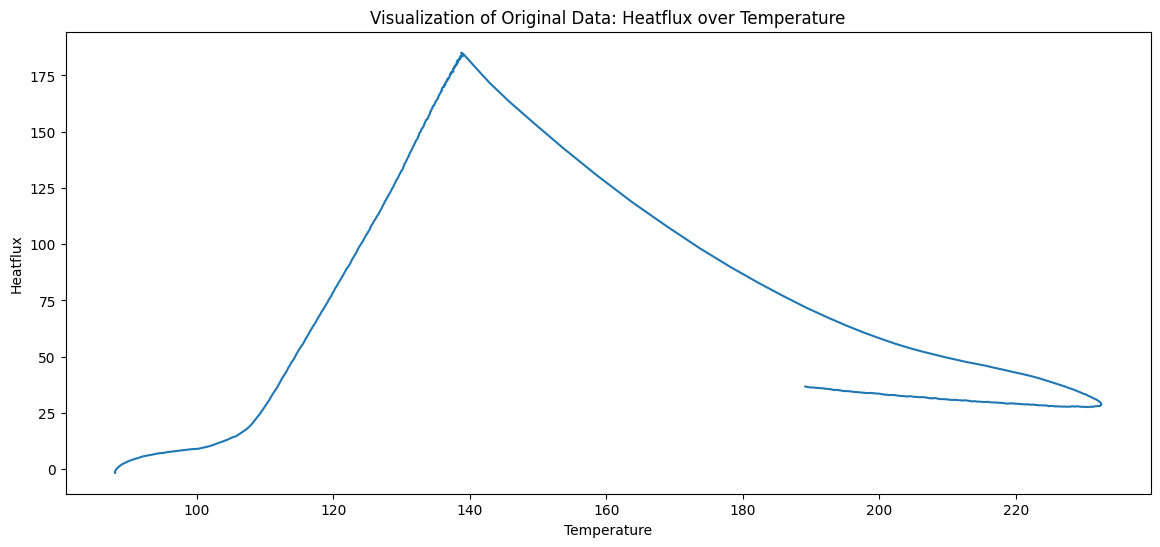

MLP Fold Progress:   0%|          | 0/10 [00:00<?, ?it/s]

GPR Fold Progress:   0%|          | 0/10 [00:00<?, ?it/s]

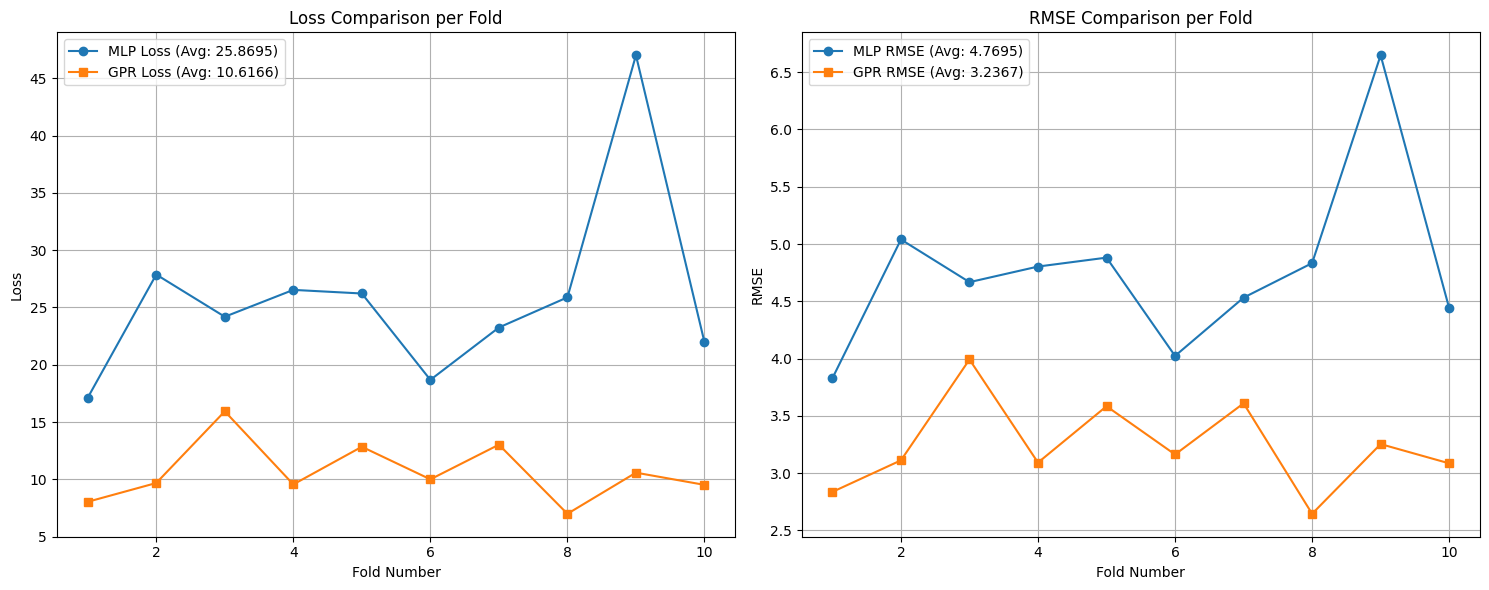

32/32 [==============================] - 0s 2ms/step


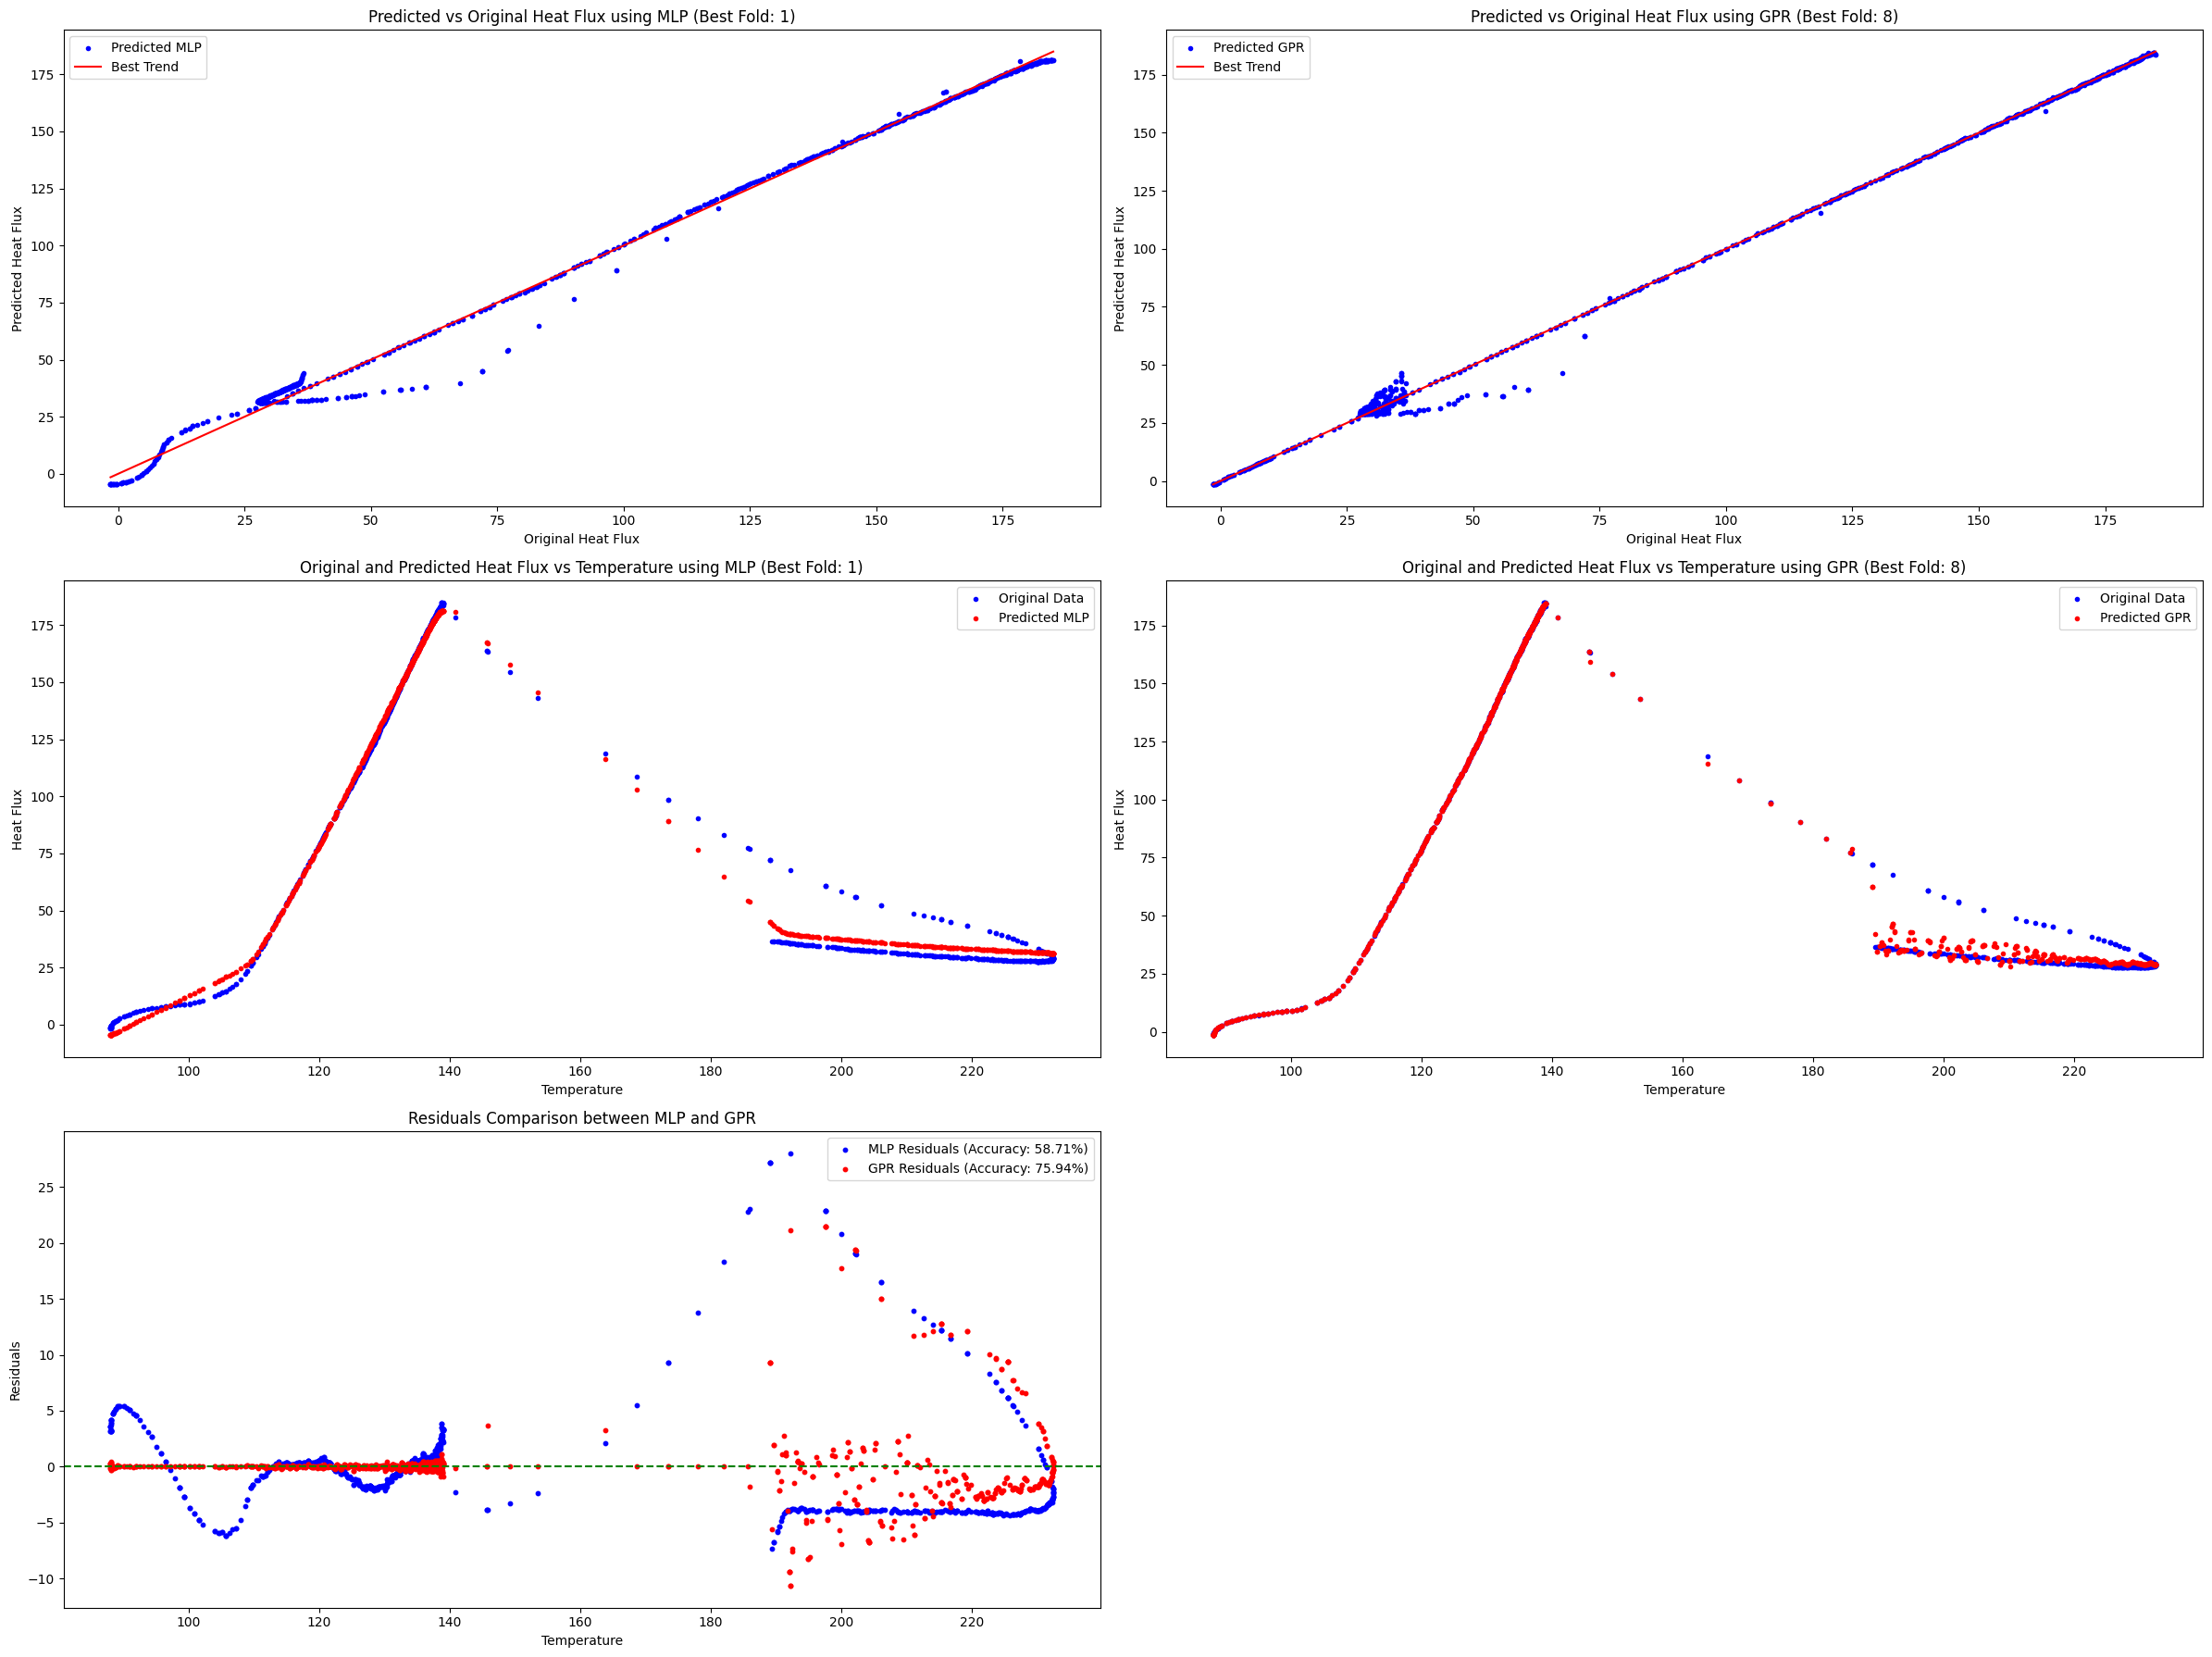

In [ ]:
# Load the data from the user-uploaded file.
X, y = load_data()

# Split the data into a temporary set (for cross-validation) and a test set.
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Specify the number of folds for k-fold cross-validation.
n_splits = 10

# Perform k-fold cross-validation for both the MLP and GPR models.
results_mlp = k_fold_cross_validation(train_mlp_model, X_temp, y_temp, n_splits, "MLP")
results_gpr = k_fold_cross_validation(train_gpr_model, X_temp, y_temp, n_splits, "GPR")

# Visualize the comparison of loss and RMSE between the MLP and GPR models.
plot_loss_and_rmse_comparison(results_mlp, results_gpr)

# Visualize the prediction results for the best MLP and GPR models on the test set.
plot_prediction_results(results_mlp, results_gpr, X_test, y_test, threshold=0.05)